In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import praw
import tqdm as tqdm
from IPython import display
from pprint import pprint
from collections import defaultdict
import pickle
from string import punctuation
from collections import Counter

plt.style.use(['dark_background'])

----
----
## Scraping data from Reddit
----
----

In [2]:
reddit = praw.Reddit(client_id='##########',
                     client_secret='##########',
                     username='##########',
                     password='##########',
                     user_agent='##########')

Version 7.0.0 of praw is outdated. Version 7.1.0 was released Tuesday June 23, 2020.


In [3]:
headlines = {}
subreddit = reddit.subreddit('worldnews').top(limit=None)

for submission in subreddit:
    if not submission.stickied:

        submission.comment_sort = 'top'
        submission.comment_limit = None

        comments = {}

        for i, top_comment in enumerate(submission.comments):
            if isinstance(top_comment, praw.models.MoreComments):
                continue
            comments[f'comment {i+1}'] = top_comment.body
            #display.clear_output()
            print(f'Comments: {len(comments)}')

    headlines[submission.title] = comments

    display.clear_output()
    print(f'Headlines: {len(headlines)}')

----
### Save and Reload Headlines Dictionary
----

In [4]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# pickle.dump(headlines, open('headlines.pkl', 'wb'))
data = load_obj('headlines')
type(data)

dict

In [5]:
next(iter(data.keys()))

'Trump Impeached for Abuse of Power'

In [6]:
df = pd.DataFrame(data).T
df.columns = df.columns.str.replace(' ', '_')
df = df.reset_index().rename(columns={'index': 'headline'})
df.head(1)

,headline,comment_1,comment_2,comment_3,comment_4,comment_5,comment_6,comment_7,comment_8,comment_9,...,comment_55,comment_56,comment_57,comment_58,comment_59,comment_60,comment_61,comment_62,comment_63,comment_64
0,Trump Impeached for Abuse of Power,UPDATE: vote on impeachment for Obstruction of...,Friendly reminder to vote in the next election...,Okay for everyone wondering what impeachment i...,"Just a reminder to everyone, unfortunately thi...",Rep. Loudermilk actually compared Trump’s tria...,[deleted],I have lived long enough to see 2 presidents i...,**The Accusation:**\n\n* President trump held ...,"Regardless of the outcome of this trial, there...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----
----
## Cleaning the Data
----
----

In [7]:
df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')) # Remove emojis
df = df.replace(r'\/r\/', '', regex=True)
df = df.replace(r'\/u\/', '', regex=True)
df = df.replace(r'https?:\/\/(www\.)?\S', '', regex=True) # Remove https links
df = df.replace(r'tatus\/\w+\?s=\d+', '', regex=True)
df = df.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', regex=True)
df = df.replace(r'([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', regex=True)
df = df.replace(r'(\w)+\.com\/\w+\/\w?', '', regex=True)
df = df.replace(r'.co\/(\w)+', '', regex=True).replace(r':', '', regex=True) # Remove co links
df = df.replace(r'https…', '', regex=True) # edge case
df = df.replace(r'\n', ' ', regex=True) # Remove newline
# df = df.applymap(lambda x: x.strip() if type(x) == str else x).astype(str)

df = df.replace(r'[deleted]', 'N/A').replace(r'[removed]', 'N/A')
df = df.replace(r'>', '', regex=True)
df = df.replace(r'\*\*', '', regex=True).replace(r'\*', '', regex=True)
df = df.fillna('N/A').replace(r'nan', 'N/A', regex=True)
df.head(1)

,headline,comment_1,comment_2,comment_3,comment_4,comment_5,comment_6,comment_7,comment_8,comment_9,...,comment_55,comment_56,comment_57,comment_58,comment_59,comment_60,comment_61,comment_62,comment_63,comment_64
0,Trump Impeached for Abuse of Power,UPDATE vote on impeachment for Obstruction of ...,Friendly reminder to vote in the next election...,Okay for everyone wondering what impeachment i...,"Just a reminder to everyone, unfortunately thi...",Rep. Loudermilk actually compared Trumps trial...,N/A,I have lived long enough to see 2 presidents i...,The Accusation President trump held Congress...,"Regardless of the outcome of this trial, there...",...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


----
----
## NLTK for Headline
----
----

In [8]:
sia = SentimentIntensityAnalyzer()

scores = [sia.polarity_scores(item) for item in df['headline']]
scores_df = pd.DataFrame(scores)
sia_df = pd.concat([df, scores_df], axis=1)

cols = sia_df.columns.to_list()
sia_df = sia_df[[cols[0]] + cols[-4:] + cols[1:-4]]

# sia_df.to_csv('sia_df-2.csv', index=False, header=sia_df.columns.values)
sia_df.head(2)

,headline,neg,neu,pos,compound,comment_1,comment_2,comment_3,comment_4,comment_5,...,comment_55,comment_56,comment_57,comment_58,comment_59,comment_60,comment_61,comment_62,comment_63,comment_64
0,Trump Impeached for Abuse of Power,0.457,0.543,0.000,-0.6369,UPDATE vote on impeachment for Obstruction of ...,Friendly reminder to vote in the next election...,Okay for everyone wondering what impeachment i...,"Just a reminder to everyone, unfortunately thi...",Rep. Loudermilk actually compared Trumps trial...,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,"Two weeks before his inauguration, Donald J. T...",0.000,0.902,0.098,0.5233,This seems like kind of a big deal.,It still baffles me this is real life.,Upvote this shit to the top so everyone knows ...,"I remember my first job, I got fired for being...","Okay, but what do we do?",...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


----
----
## NLTK for each Comment
----
----

In [9]:
df = pd.read_csv('data/sia_df-24.csv', lineterminator='\n')
df.head(2)

,headline,comment_1,comment_2,comment_3,comment_4,comment_5,comment_6,comment_7,comment_8,comment_9,...,comment_15,comment_16,comment_17,comment_18,comment_19,comment_20,comment_21,comment_22,comment_23,comment_24
0,Trump Impeached for Abuse of Power,UPDATE vote on impeachment for Obstruction of ...,Friendly reminder to vote in the next election...,Okay for everyone wondering what impeachment i...,"Just a reminder to everyone, unfortunately thi...",Rep. Loudermilk actually compared Trumps trial...,NaN,I have lived long enough to see 2 presidents i...,The Accusation President trump held Congress...,"Regardless of the outcome of this trial, there...",...,Even if it's symbolic and might not change any...,#TRUMP DOUBLE IMPEACHED,"After Trumps impeachment, what are the odds he...",I really wish I could be excited about this bu...,Can someone ELI5 what happens now and what it ...,And it still feels like any other day.,First Republican impeachment Trump loves his r...,It's too bad that 2 prominent Republicans have...,Please contact your senators this week and ple...,So to get this right and understand correctly;...
1,"Two weeks before his inauguration, Donald J. T...",This seems like kind of a big deal.,It still baffles me this is real life.,Upvote this shit to the top so everyone knows ...,"I remember my first job, I got fired for being...","Okay, but what do we do?","After the briefings, Mr. Trump issued a statem...",Man all this stuff is going to be amazing in f...,The longer this congress goes without taking a...,"Trump is the President, he's had access to all...",...,This seems to be a national emergency.,"In July 2017, just after meeting Mr. Putin for...","I think it needs reminding that John Locke, of...",Well if this isn't the end of his presidency t...,!-- FOR ANYONE WHO CAN'T READ THE ARTICLE (Ctr...,Worst president ever.,Its so disappointing that weve become so desen...,Does anyone else feel like this last week has ...,Fox News now heres how this was Obamas fault,#\#TRE45ON


In [10]:
sia = SentimentIntensityAnalyzer()

comment_compounds = []

for idx, value in enumerate(range(1, df.shape[1])):
    score = [sia.polarity_scores(str(value))['compound'] for value in df.iloc[:, idx]]
    score_df = pd.DataFrame(score, columns=[f'{idx}_compound'])
    comment_compounds.append(score_df)

comment_df = pd.concat(comment_compounds, axis=1)
compound_df = pd.concat([df, comment_df], axis=1)

compound_df = compound_df.rename(columns={'0_compound':'headline_compound'})
cols = compound_df.columns.to_list()

col_new = cols[:25]
col_old = cols[25:]
cols_final = [j for i in zip(col_new, col_old) for j in i]
df = compound_df[cols_final]

# df.to_csv('comment_compound.csv', index=False, header=df.columns.values)

df.head(2)

,headline,headline_compound,comment_1,1_compound,comment_2,2_compound,comment_3,3_compound,comment_4,4_compound,...,comment_19,19_compound,comment_20,20_compound,comment_21,21_compound,comment_22,22_compound,comment_23,23_compound
0,Trump Impeached for Abuse of Power,-0.6369,UPDATE vote on impeachment for Obstruction of ...,0.0000,Friendly reminder to vote in the next election...,0.4939,Okay for everyone wondering what impeachment i...,0.8439,"Just a reminder to everyone, unfortunately thi...",-0.3400,...,Can someone ELI5 what happens now and what it ...,0.4497,And it still feels like any other day.,0.3612,First Republican impeachment Trump loves his r...,0.5719,It's too bad that 2 prominent Republicans have...,-0.5267,Please contact your senators this week and ple...,0.5574
1,"Two weeks before his inauguration, Donald J. T...",0.5233,This seems like kind of a big deal.,0.3612,It still baffles me this is real life.,0.0000,Upvote this shit to the top so everyone knows ...,0.0000,"I remember my first job, I got fired for being...",-0.5574,...,!-- FOR ANYONE WHO CAN'T READ THE ARTICLE (Ctr...,0.9938,Worst president ever.,-0.6249,Its so disappointing that weve become so desen...,-0.3064,Does anyone else feel like this last week has ...,0.3612,Fox News now heres how this was Obamas fault,-0.4019


----
### Mean Comment Compound
----

In [11]:
num_only = df.drop_duplicates().copy()
# df.drop_duplicates(inplace=True)

num_only = num_only.drop('headline_compound', axis=1)
num_only['mean'] = num_only.mean(axis=1)

df['mean'] = num_only['mean'].astype(float)
cols = df.columns.to_list()

df = df[[cols[0]] + [cols[-1]] + cols[1:-1]]
# df.to_csv('mean-compound.csv', index=False, header=df.columns.values)
df.head(2)

,headline,mean,headline_compound,comment_1,1_compound,comment_2,2_compound,comment_3,3_compound,comment_4,...,comment_19,19_compound,comment_20,20_compound,comment_21,21_compound,comment_22,22_compound,comment_23,23_compound
0,Trump Impeached for Abuse of Power,0.246404,-0.6369,UPDATE vote on impeachment for Obstruction of ...,0.0000,Friendly reminder to vote in the next election...,0.4939,Okay for everyone wondering what impeachment i...,0.8439,"Just a reminder to everyone, unfortunately thi...",...,Can someone ELI5 what happens now and what it ...,0.4497,And it still feels like any other day.,0.3612,First Republican impeachment Trump loves his r...,0.5719,It's too bad that 2 prominent Republicans have...,-0.5267,Please contact your senators this week and ple...,0.5574
1,"Two weeks before his inauguration, Donald J. T...",-0.039230,0.5233,This seems like kind of a big deal.,0.3612,It still baffles me this is real life.,0.0000,Upvote this shit to the top so everyone knows ...,0.0000,"I remember my first job, I got fired for being...",...,!-- FOR ANYONE WHO CAN'T READ THE ARTICLE (Ctr...,0.9938,Worst president ever.,-0.6249,Its so disappointing that weve become so desen...,-0.3064,Does anyone else feel like this last week has ...,0.3612,Fox News now heres how this was Obamas fault,-0.4019


----
### Classifying the Sentiment
----

In [12]:
df['headline_label'] = 0
df['crowd_label'] = 0

# Headline Sentiment
df.loc[df['headline_compound'] > 0.15, 'headline_label'] = 1
df.loc[df['headline_compound'] < -0.15, 'headline_label'] = -1

# Sentiment of the Crowd
df.loc[df['mean'] > 0.15, 'crowd_label'] = 1
df.loc[df['mean'] < -0.15, 'crowd_label'] = -1

values = [df['headline_label'].value_counts(normalize=True), 
          df['crowd_label'].value_counts(normalize=True),
          df['headline_label'].value_counts(), 
          df['crowd_label'].value_counts()]

cols = ['headline_%', 'crowd_%', 'headline_count', 'crowd_count']

value_count_df = pd.concat(values, axis=1)
value_count_df.columns = cols
value_count_df

,headline_%,crowd_%,headline_count,crowd_count
-1,0.504523,0.236181,502,235
0,0.290452,0.602010,289,599
1,0.205025,0.161809,204,161


----
----
# Exploratory Data Analysis
----
----

----
### Headlines CountVectorizor
----

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

df = df.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
df.fillna('N/A', inplace=True)

cv = CountVectorizer(input='content', binary=False, ngram_range=(1,1), strip_accents='ascii', stop_words='english')
cv_ft = cv.fit_transform(df['headline'])
df_cv = pd.DataFrame(cv_ft.toarray(), columns=cv.get_feature_names())

df_cv = df_cv[df_cv.columns.drop(list(df_cv.filter(regex='\d+')))]
df_cv = df_cv[df_cv.columns.drop(list(df_cv.filter(regex='_+')))]

df_cv.head()

,abandon,abandoned,abandoning,abandons,abdomen,abducted,abdul,abdulbari,able,aboriginal,...,zealand,zealanders,zelenskiy,zero,zimbabwe,zone,zones,zookeepers,zoom,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


----
----
## Frequency Distribution of words in headline based on sentiment
----
----

In [14]:
# dict(df_cv.sum(axis=0))

from nltk import ngrams, FreqDist, word_tokenize, sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))
tt = TweetTokenizer() 

df['tokenized_headline'] = df['headline'].apply(lambda x: [x for x in tt.tokenize(x) if not x in stop_words if x.isalnum()])

df['tokenized_headline'] = df['tokenized_headline'].replace(r'\d+', '', regex=True)

df.head(2)

,headline,mean,headline_compound,comment_1,1_compound,comment_2,2_compound,comment_3,3_compound,comment_4,...,20_compound,comment_21,21_compound,comment_22,22_compound,comment_23,23_compound,headline_label,crowd_label,tokenized_headline
0,trump impeached for abuse of power,0.246404,-0.6369,update vote on impeachment for obstruction of ...,0.0000,friendly reminder to vote in the next election...,0.4939,okay for everyone wondering what impeachment i...,0.8439,"just a reminder to everyone, unfortunately thi...",...,0.3612,first republican impeachment trump loves his r...,0.5719,it's too bad that 2 prominent republicans have...,-0.5267,please contact your senators this week and ple...,0.5574,-1,1,"[trump, impeached, abuse, power]"
1,"two weeks before his inauguration, donald j. t...",-0.039230,0.5233,this seems like kind of a big deal.,0.3612,it still baffles me this is real life.,0.0000,upvote this shit to the top so everyone knows ...,0.0000,"i remember my first job, i got fired for being...",...,-0.6249,its so disappointing that weve become so desen...,-0.3064,does anyone else feel like this last week has ...,0.3612,fox news now heres how this was obamas fault,-0.4019,1,0,"[weeks, inauguration, donald, j, trump, shown,..."


----
### Positive Headlines
----

In [15]:
fdist = FreqDist()

for value in df[df['headline_label'] == 1]['tokenized_headline']:
    for word in value:
        fdist[word] += 1

fdist_df = pd.DataFrame.from_dict(fdist, orient='index').rename(columns={0: 'frequency'}).rename_axis('term')

fdist_head_pos = fdist_df[~fdist_df.index.str.contains(r'[0-9]')]

fdist_head_poss = fdist_head_pos.sort_values(by='frequency', ascending=False).head(30)

fdist_head_poss.head()

,frequency
term,
trump,38
coronavirus,25
says,19
covid,16
world,16


----
### Negative Headlines
----

In [16]:
fdist = FreqDist()

for value in df[df['headline_label'] == -1]['tokenized_headline']:
    for word in value:
        fdist[word] += 1

fdist_df = pd.DataFrame.from_dict(fdist, orient='index').rename(columns={0: 'frequency'}).rename_axis('term')

fdist_head_neg = fdist_df[~fdist_df.index.str.contains(r'[0-9]')]

fdist_head_negs = fdist_head_neg.sort_values(by='frequency', ascending=False).head(30)

fdist_head_negs.head()

,frequency
term,
trump,91
says,47
coronavirus,42
people,34
china,33


----
----
## Frequency Disribution of words in comments based on sentiment
----
----

In [17]:
comments = df.select_dtypes(include='object').copy()

comments.drop(['headline', 'tokenized_headline'], axis=1, inplace=True)

comments['all_comments'] = comments.apply(lambda x: ' '.join(x.astype(str)), axis=1)

comments.head(2)

,comment_1,comment_2,comment_3,comment_4,comment_5,comment_6,comment_7,comment_8,comment_9,comment_10,...,comment_15,comment_16,comment_17,comment_18,comment_19,comment_20,comment_21,comment_22,comment_23,all_comments
0,update vote on impeachment for obstruction of ...,friendly reminder to vote in the next election...,okay for everyone wondering what impeachment i...,"just a reminder to everyone, unfortunately thi...",rep. loudermilk actually compared trumps trial...,N/A,i have lived long enough to see 2 presidents i...,the accusation president trump held congress...,"regardless of the outcome of this trial, there...",john dean (nixon's lawyer) suggests that the h...,...,even if it's symbolic and might not change any...,#trump double impeached,"after trumps impeachment, what are the odds he...",i really wish i could be excited about this bu...,can someone eli5 what happens now and what it ...,and it still feels like any other day.,first republican impeachment trump loves his r...,it's too bad that 2 prominent republicans have...,please contact your senators this week and ple...,update vote on impeachment for obstruction of ...
1,this seems like kind of a big deal.,it still baffles me this is real life.,upvote this shit to the top so everyone knows ...,"i remember my first job, i got fired for being...","okay, but what do we do?","after the briefings, mr. trump issued a statem...",man all this stuff is going to be amazing in f...,the longer this congress goes without taking a...,"trump is the president, he's had access to all...",the most gold stars ive seen,...,this seems to be a national emergency.,"in july 2017, just after meeting mr. putin for...","i think it needs reminding that john locke, of...",well if this isn't the end of his presidency t...,!-- for anyone who can't read the article (ctr...,worst president ever.,its so disappointing that weve become so desen...,does anyone else feel like this last week has ...,fox news now heres how this was obamas fault,this seems like kind of a big deal. it still b...


----
### Comments CountVectorizor
----

In [18]:
vect = CountVectorizer(input='content', binary=False, ngram_range=(1,1), strip_accents='ascii', stop_words='english')
cv_ft2 = vect.fit_transform(comments['all_comments'])
df_cv2 = pd.DataFrame(cv_ft2.toarray(), columns=vect.get_feature_names())

com = df_cv2.copy()

com = com[com.columns.drop(list(com.filter(regex='\d+')))]
com = com[com.columns.drop(list(com.filter(regex='_+')))]

com.head()

,aa,aaa,aaaaaaaaaaannndd,aaaaaaaaahahahahahaaaaa,aaaaaaaand,aaaaaaand,aaaaaahhhh,aaaaaand,aaaaahhahahahahahhahahahahahahahahah,aaaaand,...,zubayda,zuck,zuckerberg,zuckerbergs,zulu,zunyou,zurckzuhalten,zvezda,zwaan,zyl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))
tt = TweetTokenizer() 

comments['tokenized_comments'] = comments['all_comments'].apply(lambda x: [x for x in tt.tokenize(x) if not x in stop_words if x.isalnum()])

comments['tokenized_comments'] = comments['tokenized_comments'].replace(r'\d+', '', regex=True)

df['all_comments'] = comments['all_comments']
df['tokenized_comments'] = comments['tokenized_comments']

df.head(2)

,headline,mean,headline_compound,comment_1,1_compound,comment_2,2_compound,comment_3,3_compound,comment_4,...,21_compound,comment_22,22_compound,comment_23,23_compound,headline_label,crowd_label,tokenized_headline,all_comments,tokenized_comments
0,trump impeached for abuse of power,0.246404,-0.6369,update vote on impeachment for obstruction of ...,0.0000,friendly reminder to vote in the next election...,0.4939,okay for everyone wondering what impeachment i...,0.8439,"just a reminder to everyone, unfortunately thi...",...,0.5719,it's too bad that 2 prominent republicans have...,-0.5267,please contact your senators this week and ple...,0.5574,-1,1,"[trump, impeached, abuse, power]",update vote on impeachment for obstruction of ...,"[update, vote, impeachment, obstruction, congr..."
1,"two weeks before his inauguration, donald j. t...",-0.039230,0.5233,this seems like kind of a big deal.,0.3612,it still baffles me this is real life.,0.0000,upvote this shit to the top so everyone knows ...,0.0000,"i remember my first job, i got fired for being...",...,-0.3064,does anyone else feel like this last week has ...,0.3612,fox news now heres how this was obamas fault,-0.4019,1,0,"[weeks, inauguration, donald, j, trump, shown,...",this seems like kind of a big deal. it still b...,"[like, kind, big, deal, baffles, real, life, u..."


In [20]:
# df.to_pickle('final-df.pkl')
# df.to_csv('final-df.csv', index=False, header=df.columns.values)

----
### Positive Comments
----

In [21]:
fdist = FreqDist()

for value in df[df['crowd_label'] == 1]['tokenized_comments']:
    for word in value:
        fdist[word] += 1

fdist_df = pd.DataFrame.from_dict(fdist, orient='index').rename(columns={0: 'frequency'}).rename_axis('term')

fdist_com_pos = fdist_df[~fdist_df.index.str.contains(r'[0-9]')]

fdist_com_poss = fdist_com_pos.sort_values(by='frequency', ascending=False).head(30)

fdist_com_poss.head()

,frequency
term,
people,607
like,591
N,349
A,349
good,333


----
### Negative Comments
----

In [22]:
fdist = FreqDist()

for value in df[df['crowd_label'] == -1]['tokenized_comments']:
    for word in value:
        fdist[word] += 1

fdist_df = pd.DataFrame.from_dict(fdist, orient='index').rename(columns={0: 'frequency'}).rename_axis('term')

fdist_com_neg = fdist_df[~fdist_df.index.str.contains(r'[0-9]')]

fdist_com_negs = fdist_com_neg.sort_values(by='frequency', ascending=False).head(30)

fdist_com_negs.head()

,frequency
term,
people,1185
trump,696
like,665
N,560
A,560


----
----
## Combined Frequency Dataframe
----
----

In [23]:
fdist_dfs = [fdist_head_poss.reset_index(), fdist_head_negs.reset_index(), fdist_com_poss.reset_index(), fdist_com_negs.reset_index()]

tot_tf = pd.concat(fdist_dfs, axis=1)

pretty = tot_tf.T.copy()
iterables = [['head_pos', 'head_neg', 'com_pos', 'com_neg'], ['term', 'frequency']]

pretty.index = pd.MultiIndex.from_product(iterables)
pretty = pretty.T
pretty.head()

head_pos               head_neg           com_pos           com_neg  \
          term frequency         term frequency    term frequency    term   
0        trump        38        trump        91  people       607  people   
1  coronavirus        25         says        47    like       591   trump   
2         says        19  coronavirus        42       N       349    like   
3        covid        16       people        34       A       349       N   
4        world        16        china        33    good       333       A   

             
  frequency  
0      1185  
1       696  
2       665  
3       560  
4       560

In [24]:
# pretty2 = pd.DataFrame(pretty.to_records())
# pretty2.to_csv('data/pretty.csv', index=False)

----
----
## Frequency of words found in most common words
----
----

In [25]:
freq_dict = {}

freq_dict['head_pos'] = list(zip(pretty['head_pos']['term'], pretty['head_pos']['frequency']))
freq_dict['head_neg'] = list(zip(pretty['head_neg']['term'], pretty['head_neg']['frequency']))
freq_dict['com_pos'] = list(zip(pretty['com_pos']['term'], pretty['com_pos']['frequency']))
freq_dict['com_neg'] = list(zip(pretty['com_neg']['term'], pretty['com_neg']['frequency']))

words = [term for key, value in freq_dict.items() for term, frequency in value]

Counter(words).most_common(5)

[('trump', 4), ('world', 4), ('new', 4), ('china', 4), ('people', 4)]

----
----
## WordCloud
----
----

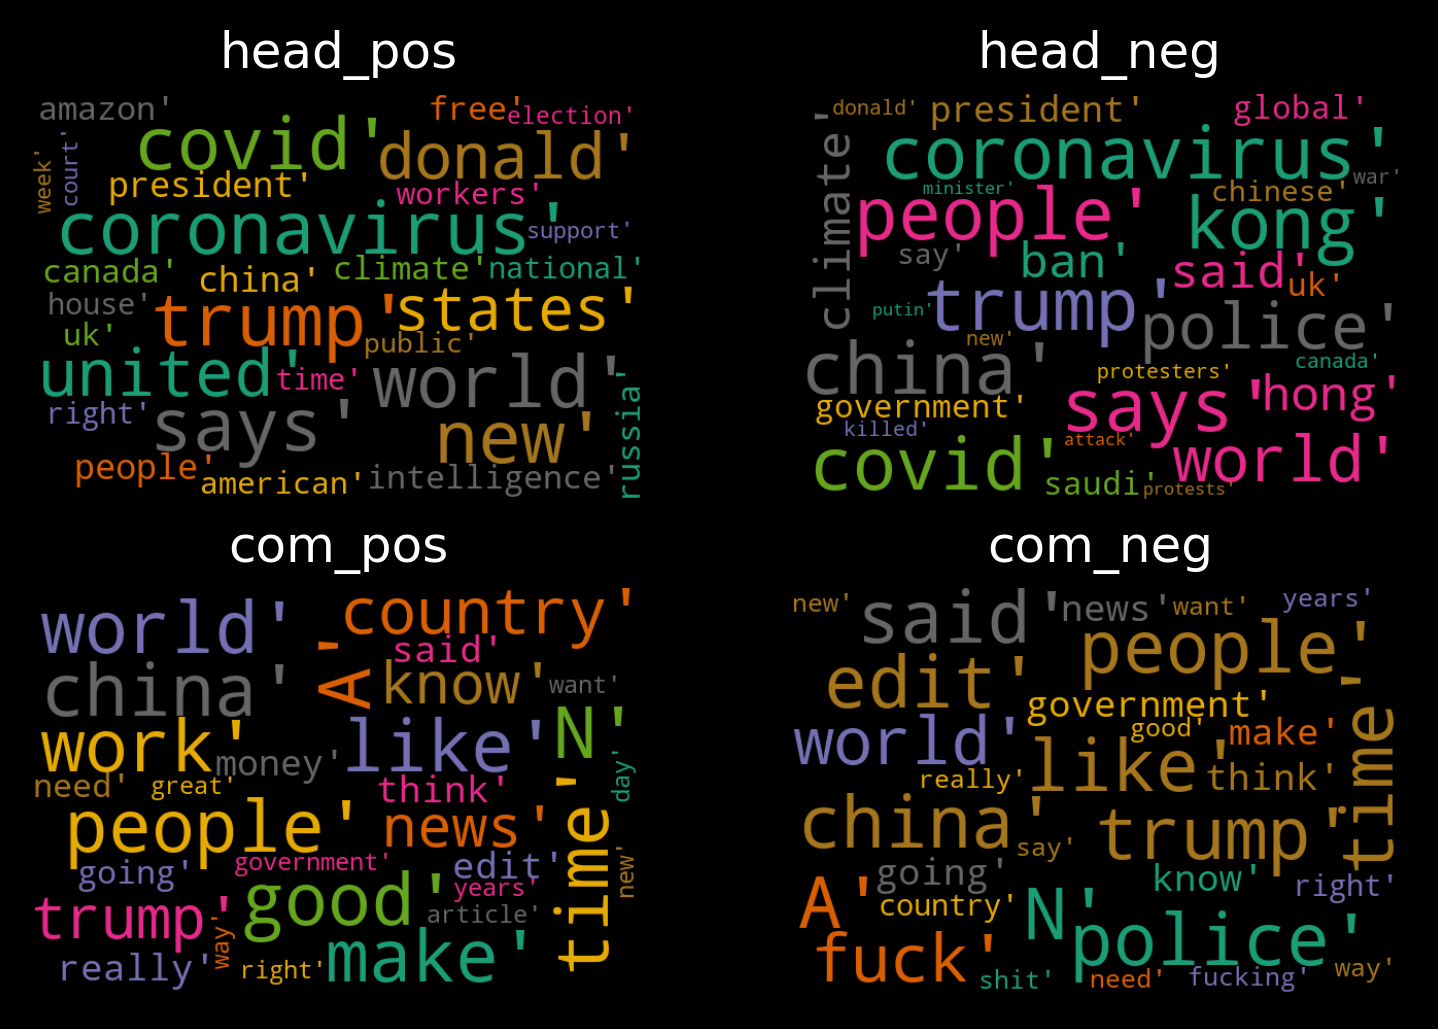

In [26]:
from wordcloud import WordCloud

word_cloud = WordCloud(stopwords=stop_words, height=400, width=600, max_font_size=70, colormap='Dark2')

plt.rcParams['figure.dpi'] = 300

cols = ['head_pos', 'head_neg', 'com_pos', 'com_neg']

for idx, (col, tf) in enumerate(pretty.columns[::2]):
    word_cloud.generate(str(pretty.xs(col, axis=1)['term'].values))

    plt.subplot(2, 2, idx+1)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(col)

plt.show()

----
----
## Overall Word Frequency of Comments
----
----

In [27]:
df2 = df.copy()
df2 = df2.set_index('headline')

com.index = df2.index
comm = com.T.copy()

# Top 30 words for the comments of each headline
top = {c: list(zip(comm[c].sort_values(ascending=False).head(30).index, 
                        comm[c].sort_values(ascending=False).head(30).values)) 
                        for c in comm.columns}

# List of all the words without their count
words = [t for c in comm.columns for t in [word for (word, count) in top[c]]]

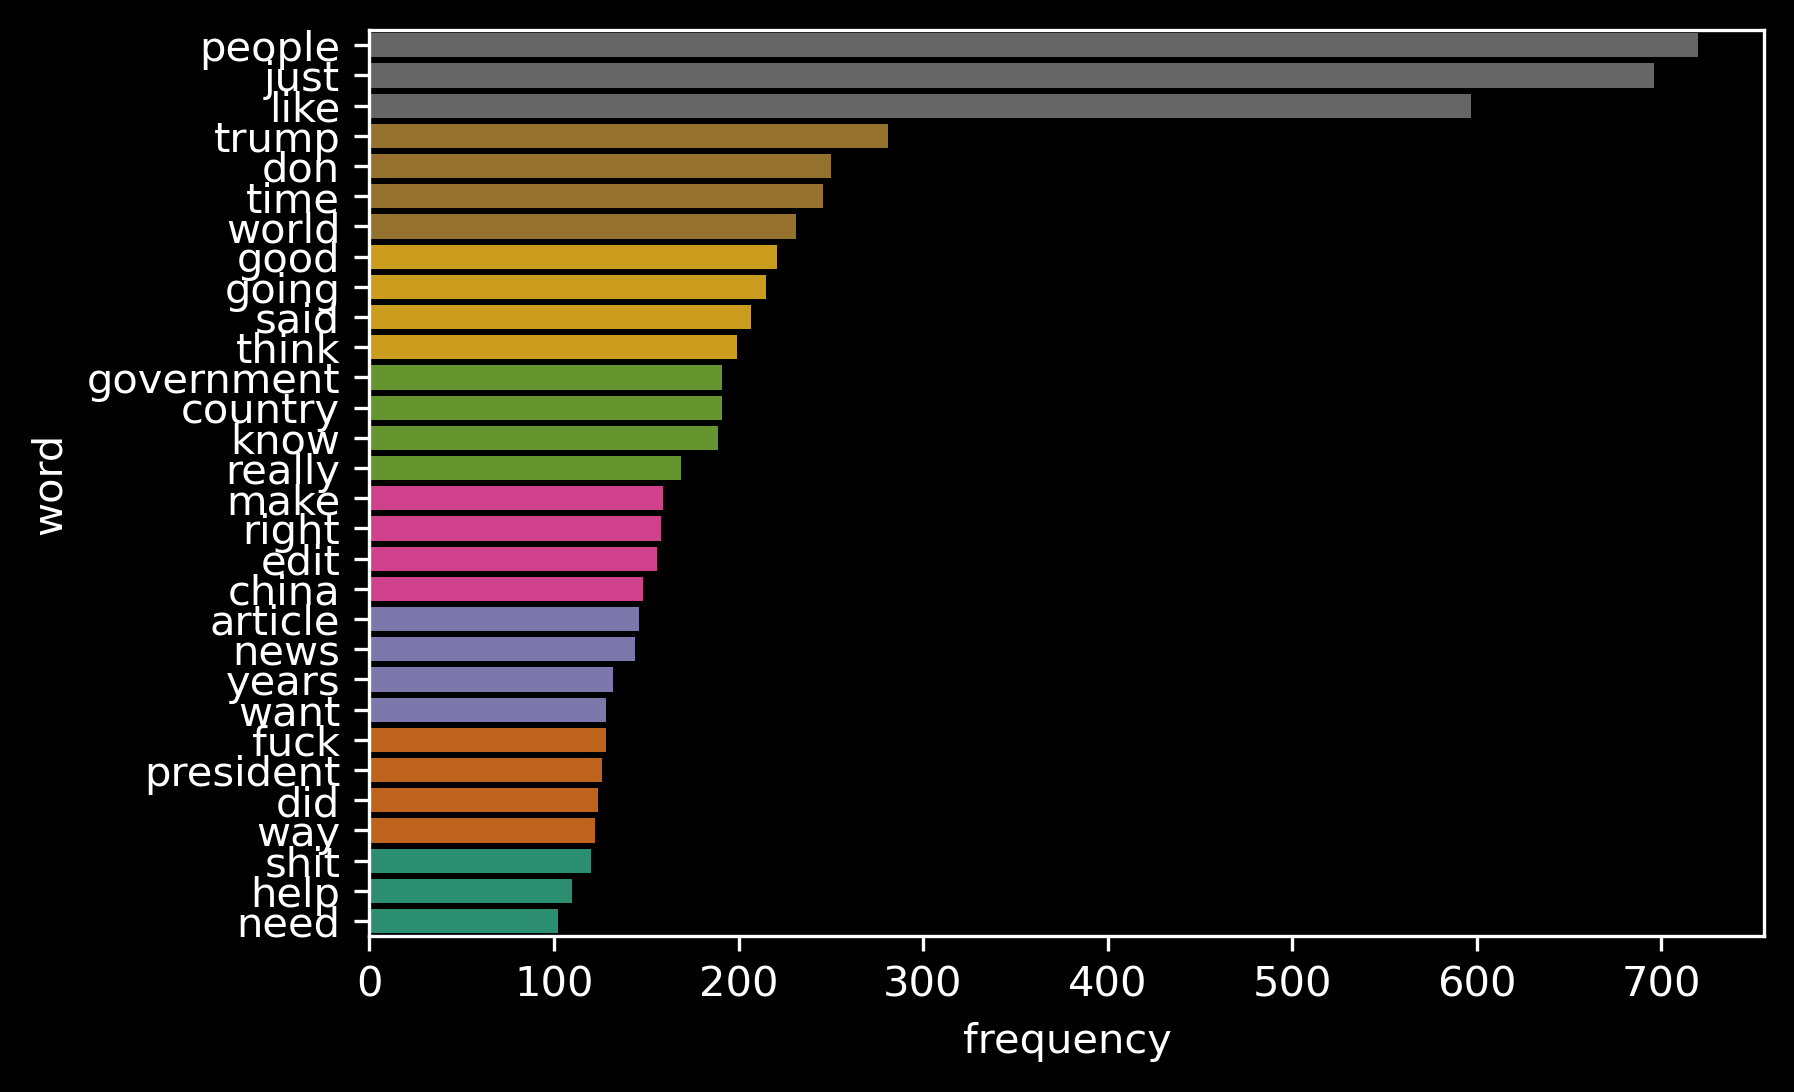

In [28]:
most_common = Counter(words).most_common()

common_df = pd.DataFrame(most_common).set_index(0).rename(columns={1: 'frequency'}).rename_axis('word')

top30 = common_df.head(30)

plt.rcParams['figure.dpi'] = 300

sns.barplot(x=top30['frequency'], y=top30.index, palette='Dark2_r');

----
----
## Unique Words found in comments for each Headline
----
----

In [29]:
unique_count = [np.array(comm[c]).nonzero()[0].shape[0] for c in comm.columns]

unique_df = pd.DataFrame(list(zip(comm.columns.values, unique_count)), columns=['headline', 'unique_count'])

unique_df.sort_values(by='unique_count', ascending=False).head()


,headline,unique_count
402,coronavirus doctors and nurses will need ptsd ...,905
33,'we don't know a planet like this' co2 levels ...,876
69,school students have been protesting in demand...,847
840,180 mayors adopt paris climate accord after . ...,835
3,terabyte leak of panamanian shell company dat...,797


----
----
## Top Bigrams in Comments
----
----

In [30]:
vect = CountVectorizer(input='content', binary=False, ngram_range=(2,2), strip_accents='ascii', stop_words='english')
cv_ft2 = vect.fit_transform(comments['all_comments'])
df_cv2 = pd.DataFrame(cv_ft2.toarray(), columns=vect.get_feature_names())

com = df_cv2.copy()

com = com[com.columns.drop(list(com.filter(regex='\d+')))]
com = com[com.columns.drop(list(com.filter(regex='_+')))]

In [31]:
df2 = df.copy()
df2 = df2.set_index('headline')

com.index = df2.index
comm = com.T.copy()

# Top 30 words for the comments of each headline
top = {c: list(zip(comm[c].sort_values(ascending=False).head(30).index, 
                        comm[c].sort_values(ascending=False).head(30).values)) 
                        for c in comm.columns}

# List of all the words without their count
words = [t for c in comm.columns for t in [word for (word, count) in top[c]]]

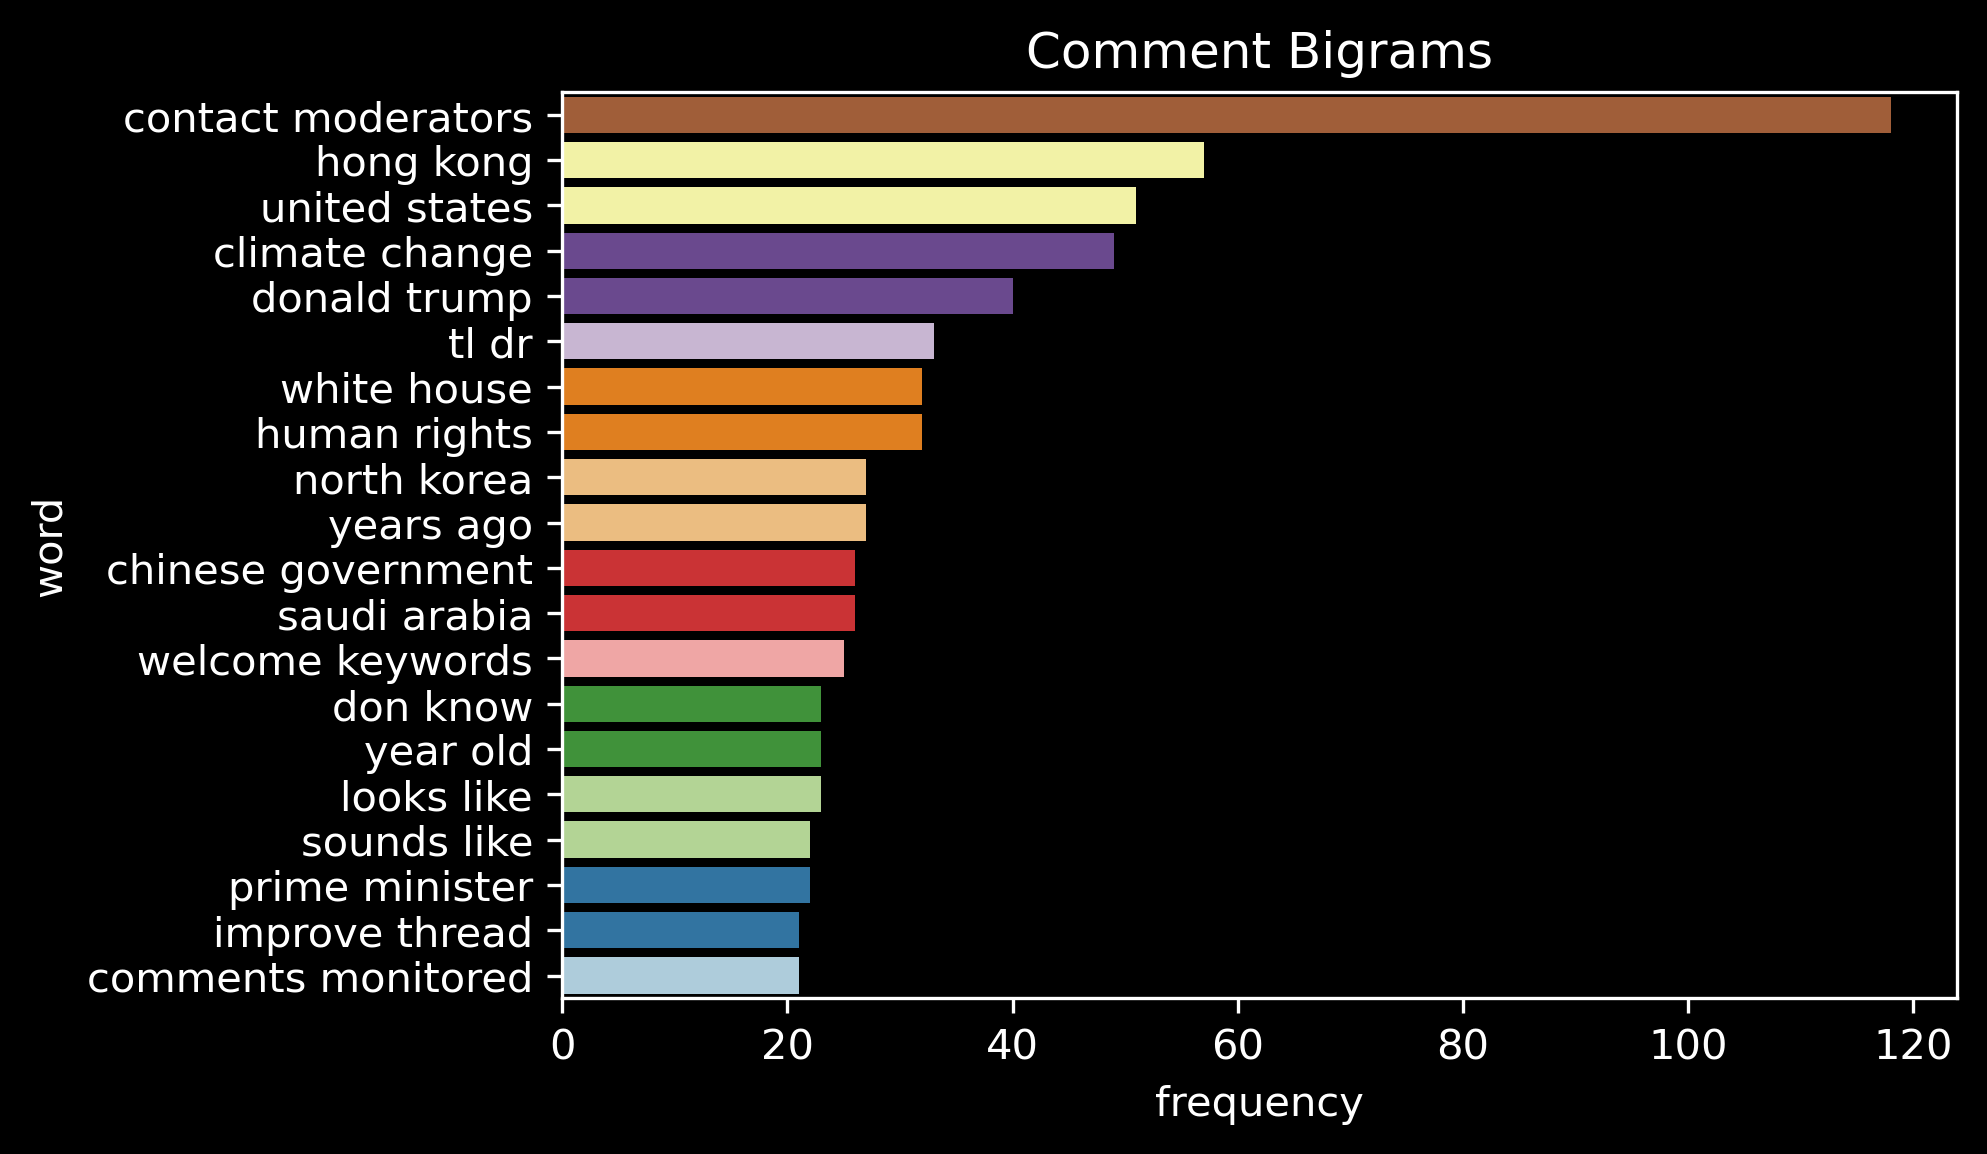

In [32]:
most_common = Counter(words).most_common()

common_df = pd.DataFrame(most_common).set_index(0).rename(columns={1: 'frequency'}).rename_axis('word')

top20 = common_df.head(20)

plt.rcParams['figure.dpi'] = 300

sns.barplot(x=top20['frequency'], y=top20.index, palette='Paired_r')
plt.title('Comment Bigrams');

----
----
## Number of Words in Headline
----
----

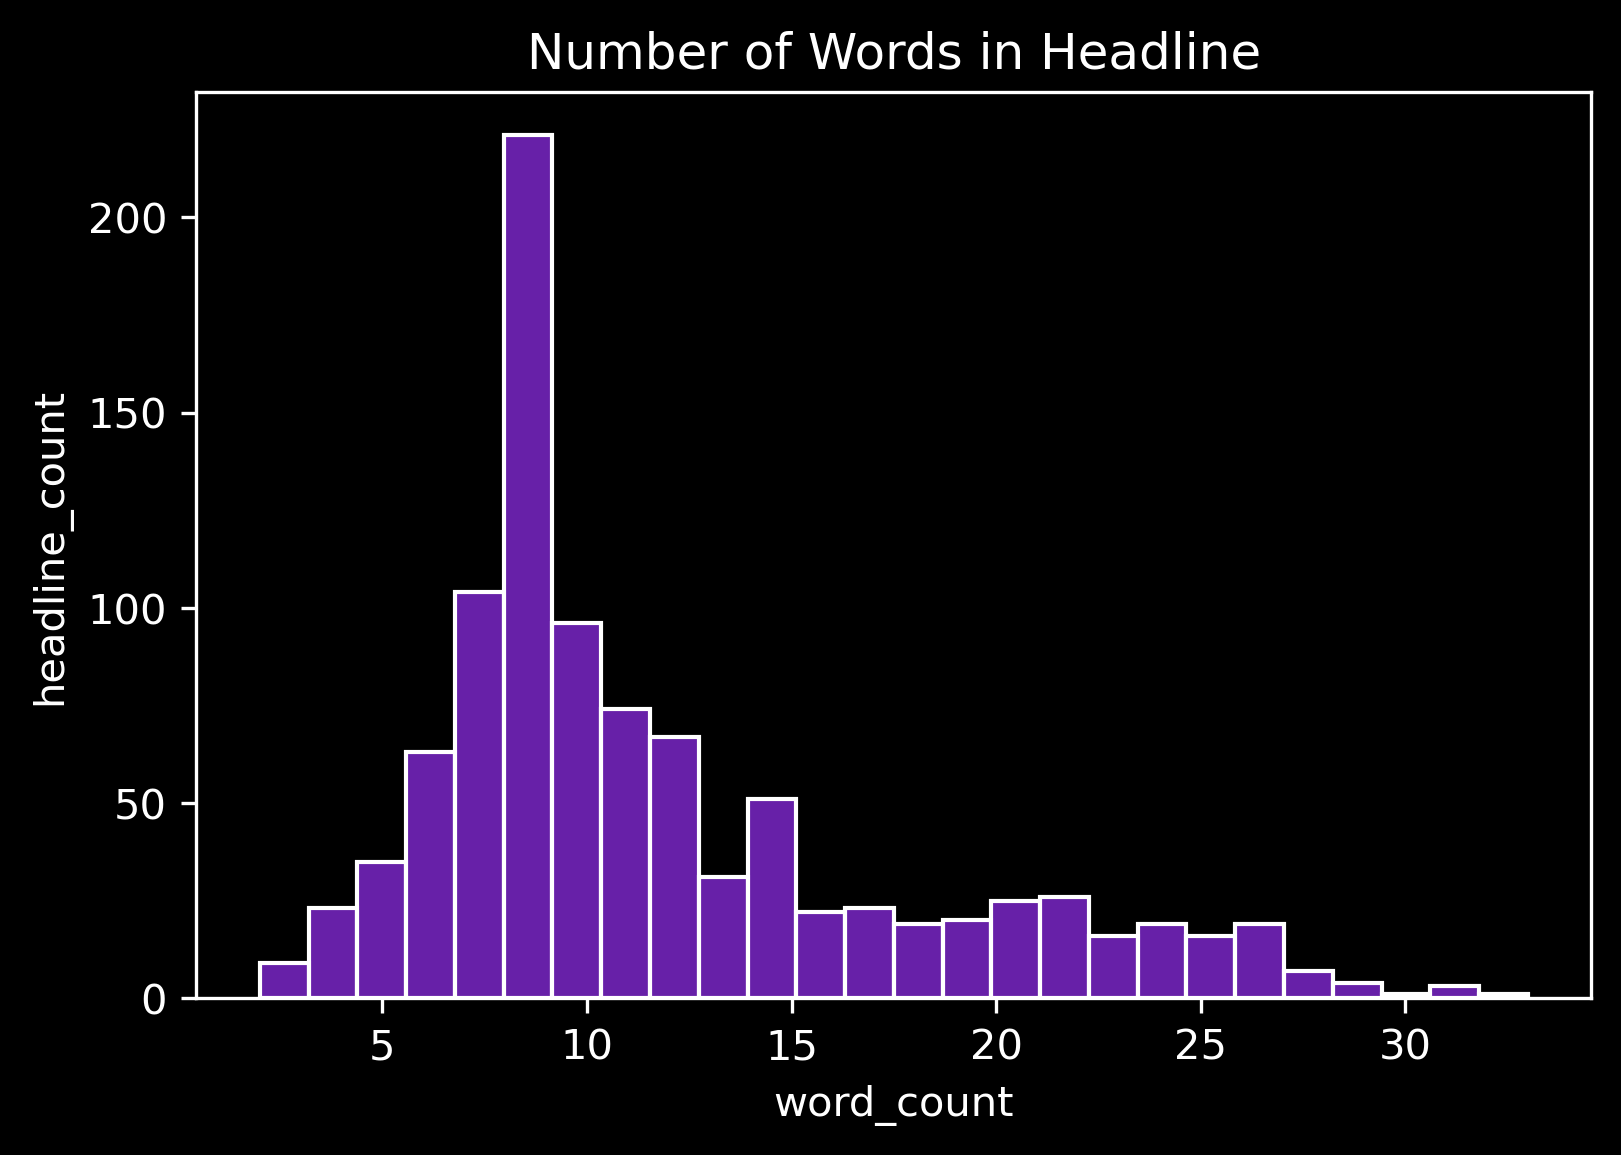

In [33]:
headline = pd.DataFrame(df['tokenized_headline'].astype(str).str.replace(r"'", '', regex=True).replace(r'\,', '', regex=True).replace(r'\[', '', regex=True).replace(r'\]', '', regex=True))

headline['word_count'] = headline['tokenized_headline'].str.split().str.len()

sns.histplot(headline['word_count'], color='BlueViolet')
plt.title('Number of Words in Headline')
plt.ylabel('headline_count')
plt.xlabel('word_count');

----
----
## Average Length of Words in Headlines
----
----

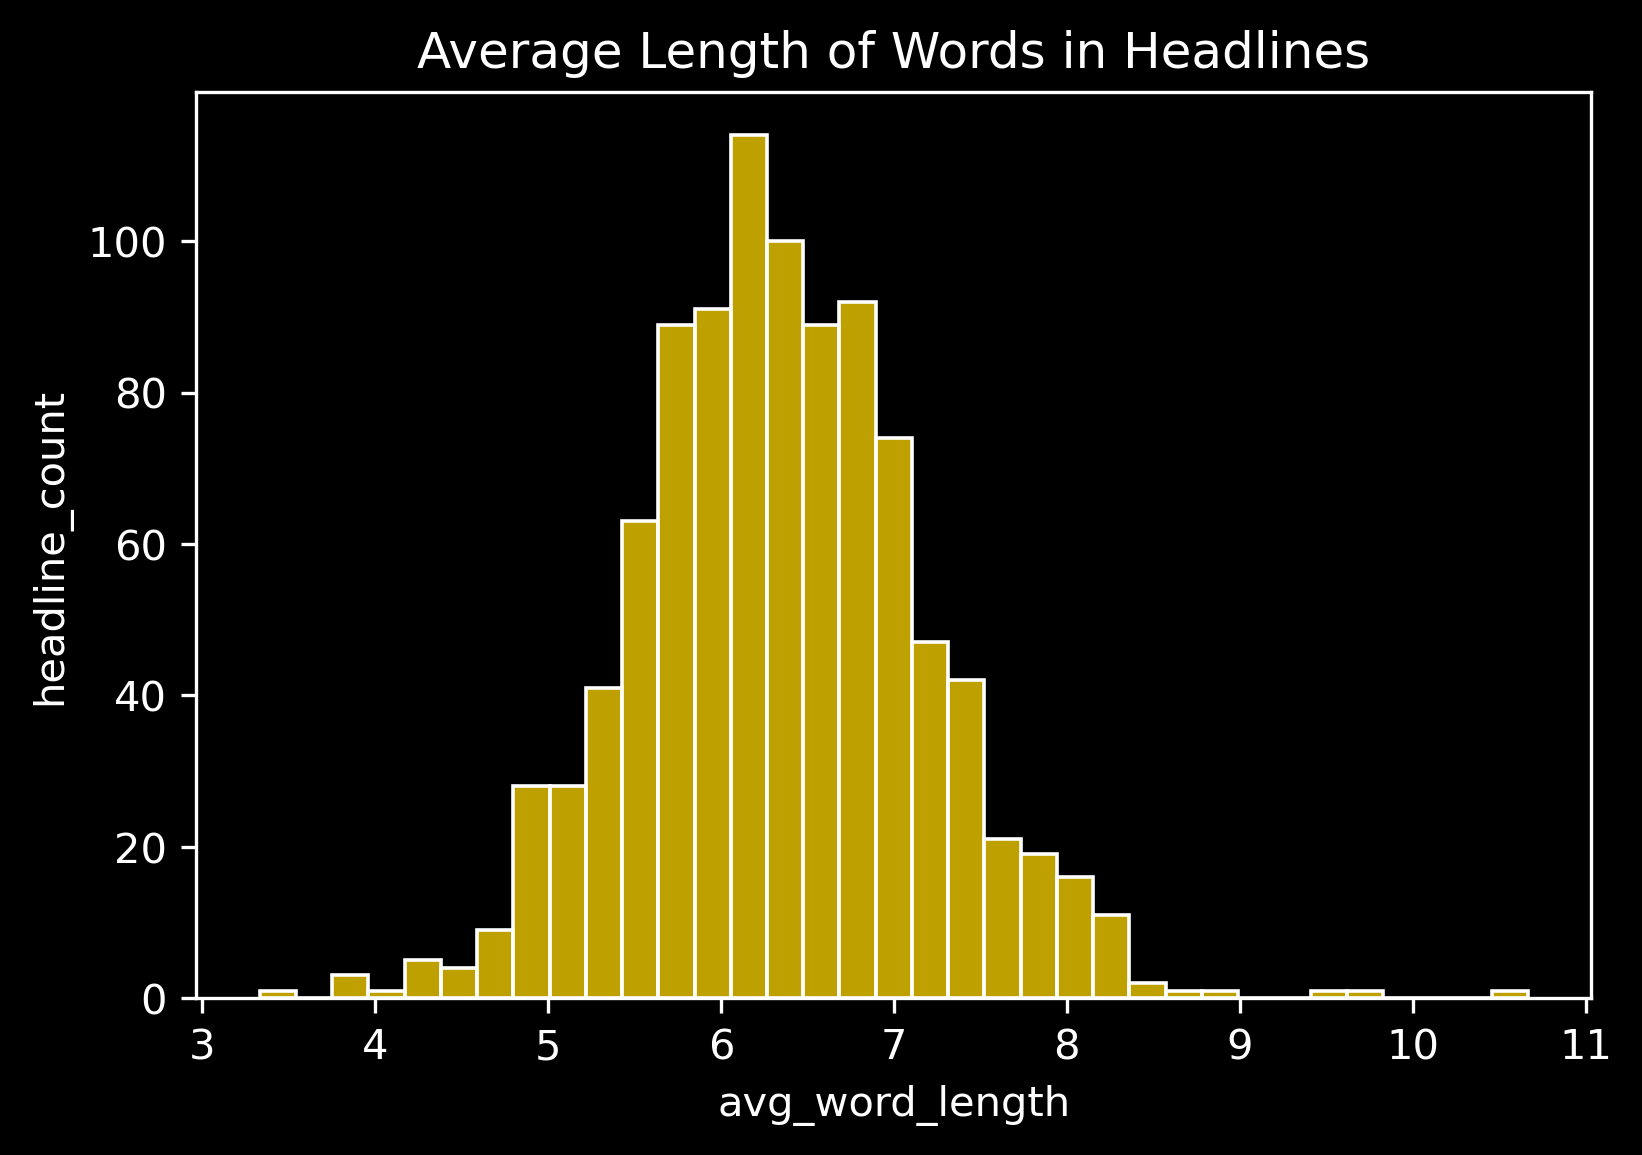

In [34]:
headline['avg_word_length'] = headline['tokenized_headline'].str.split().apply(lambda x: sum(map(len, x))/len(x))

sns.histplot(headline['avg_word_length'], color='Gold')
plt.title('Average Length of Words in Headlines')
plt.ylabel('headline_count');

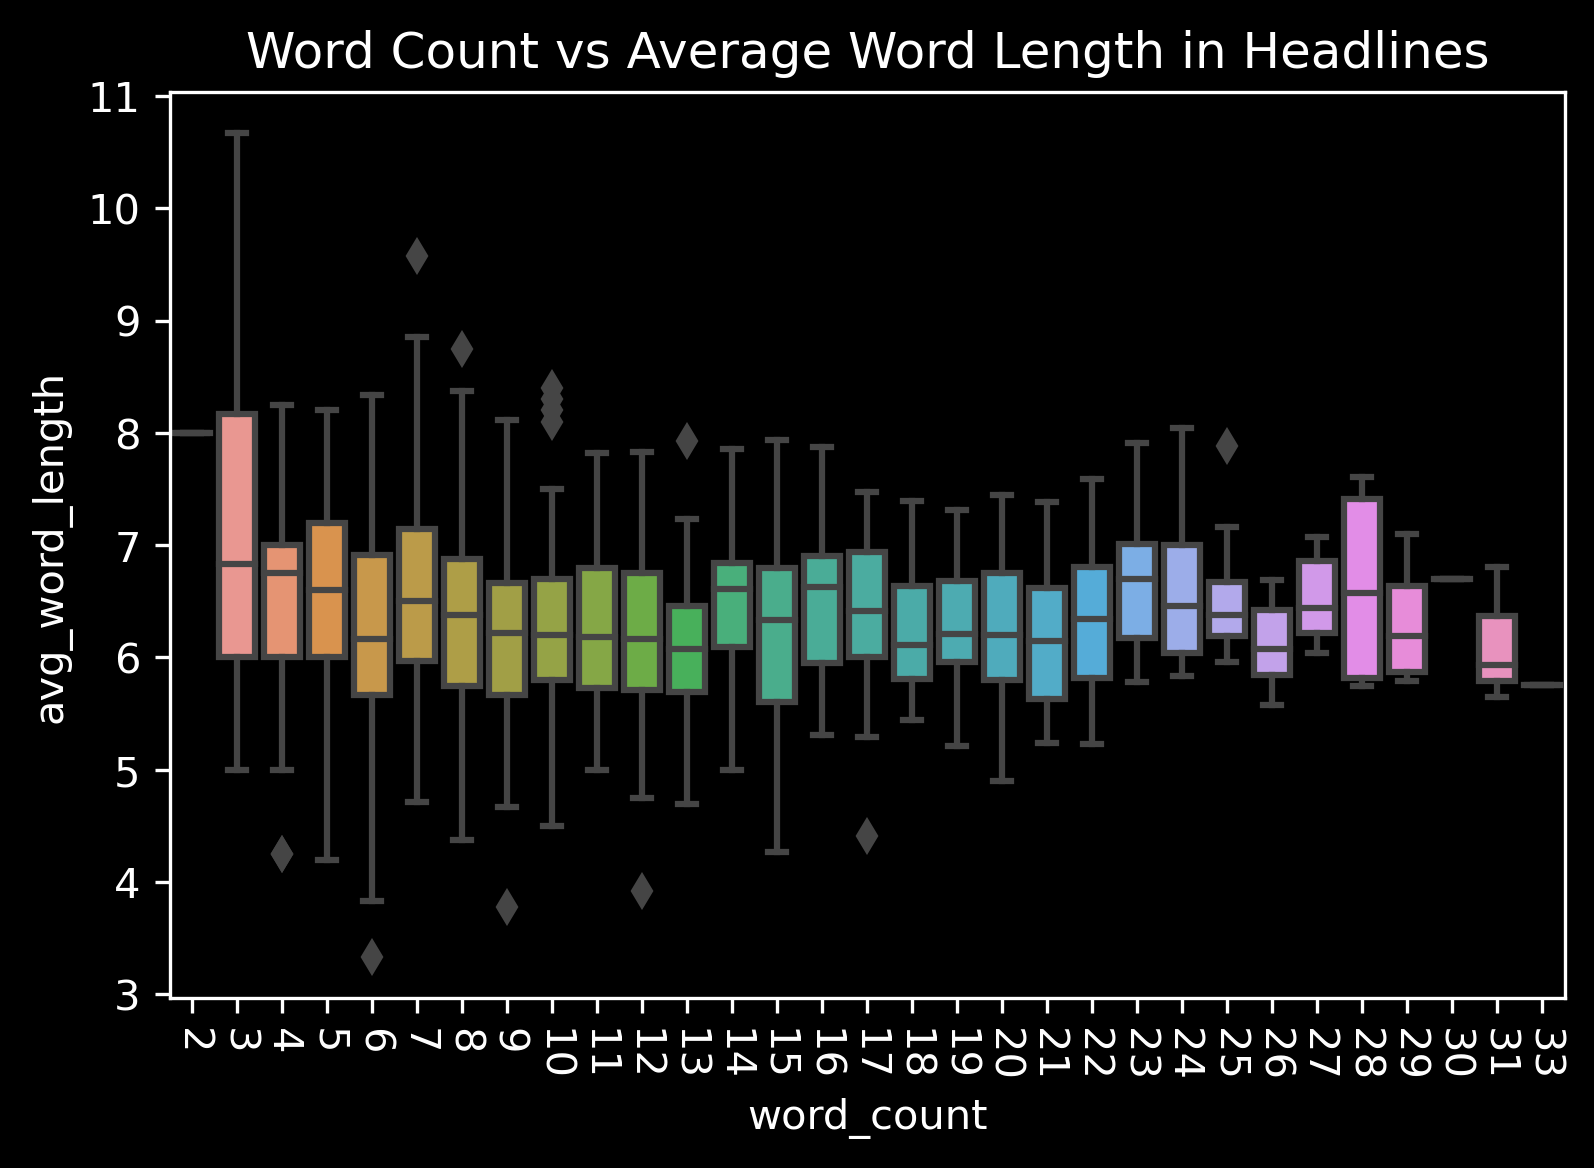

In [35]:
sns.boxplot(headline['word_count'], headline['avg_word_length'])
plt.title('Word Count vs Average Word Length in Headlines')
plt.xticks(rotation=-90);

----
----
## Average Comment Sentiment Score
----
----

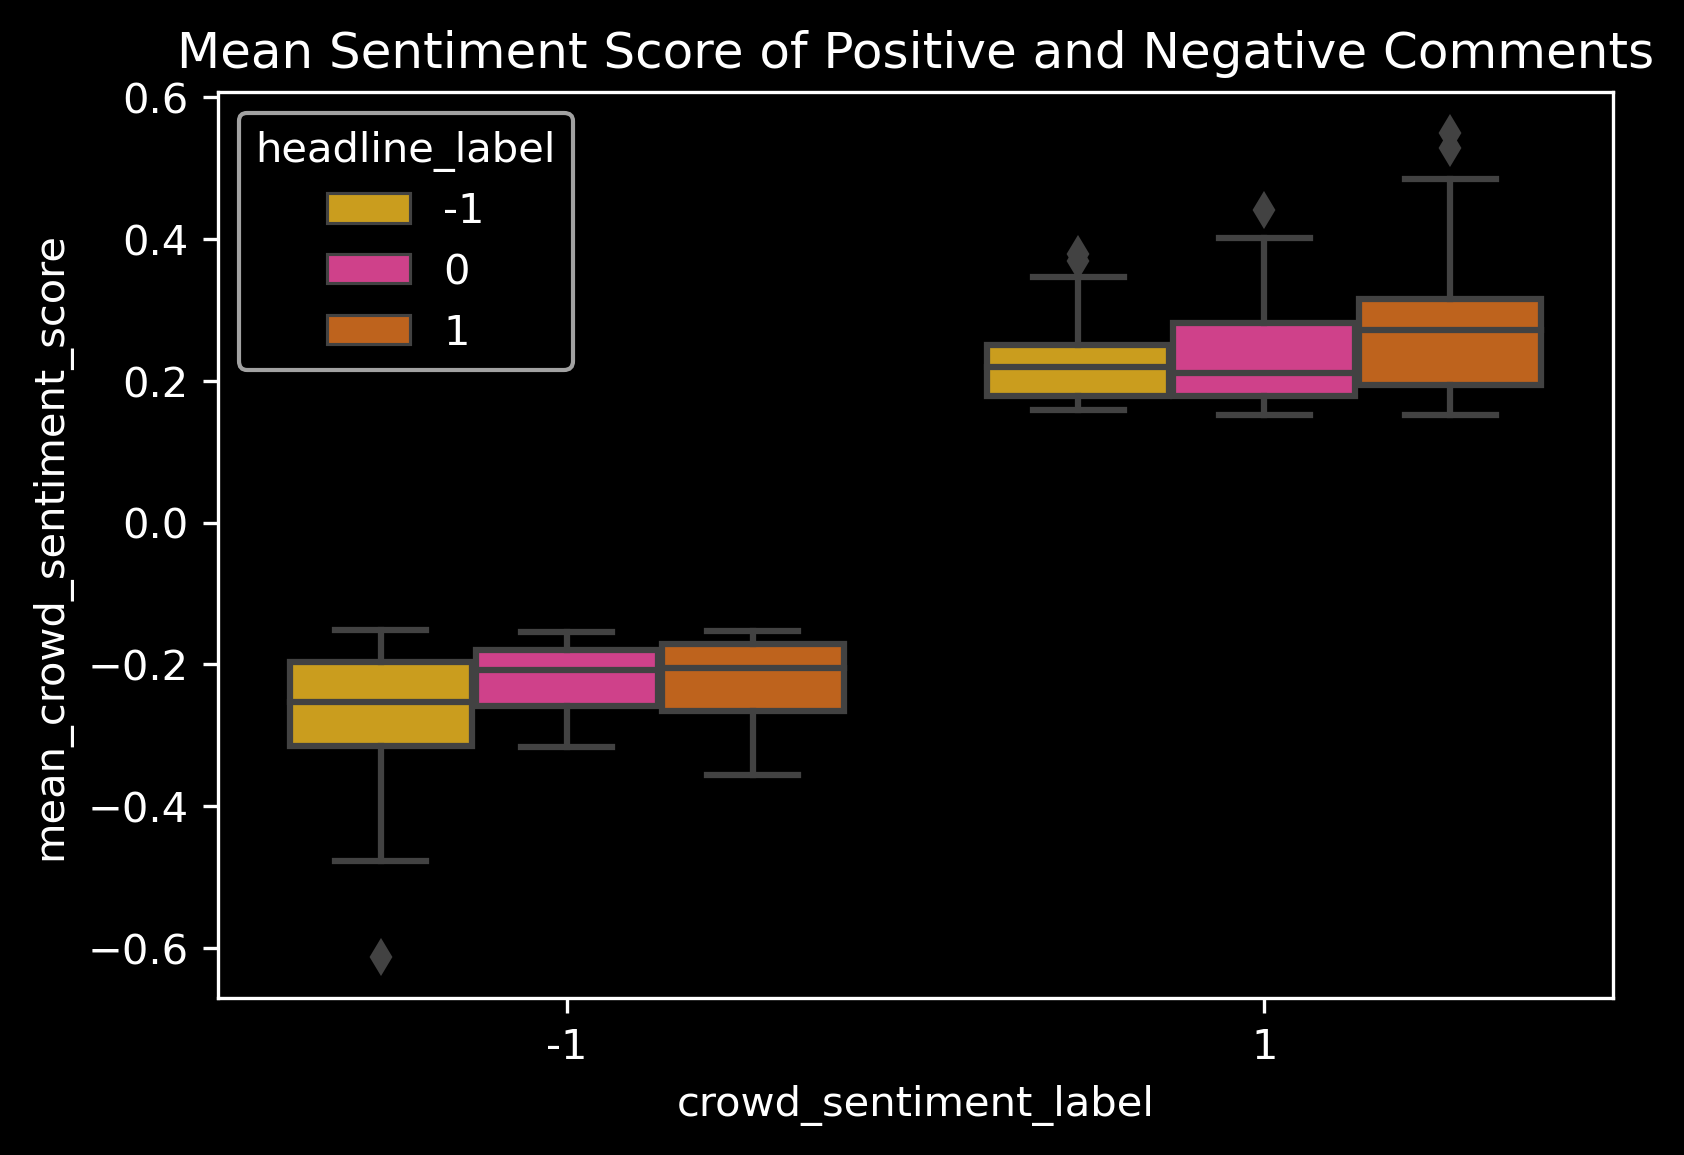

In [36]:
sns.boxplot(data=df, x=df.loc[df['crowd_label'] != 0, 'crowd_label'], 
                        y=df.loc[df['crowd_label'] != 0, 'mean'], 
                        palette='Dark2_r', hue='headline_label')

plt.xlabel('crowd_sentiment_label')
plt.ylabel('mean_crowd_sentiment_score')
plt.title('Mean Sentiment Score of Positive and Negative Comments');

----
----
## Named Entity Recognition
----
----

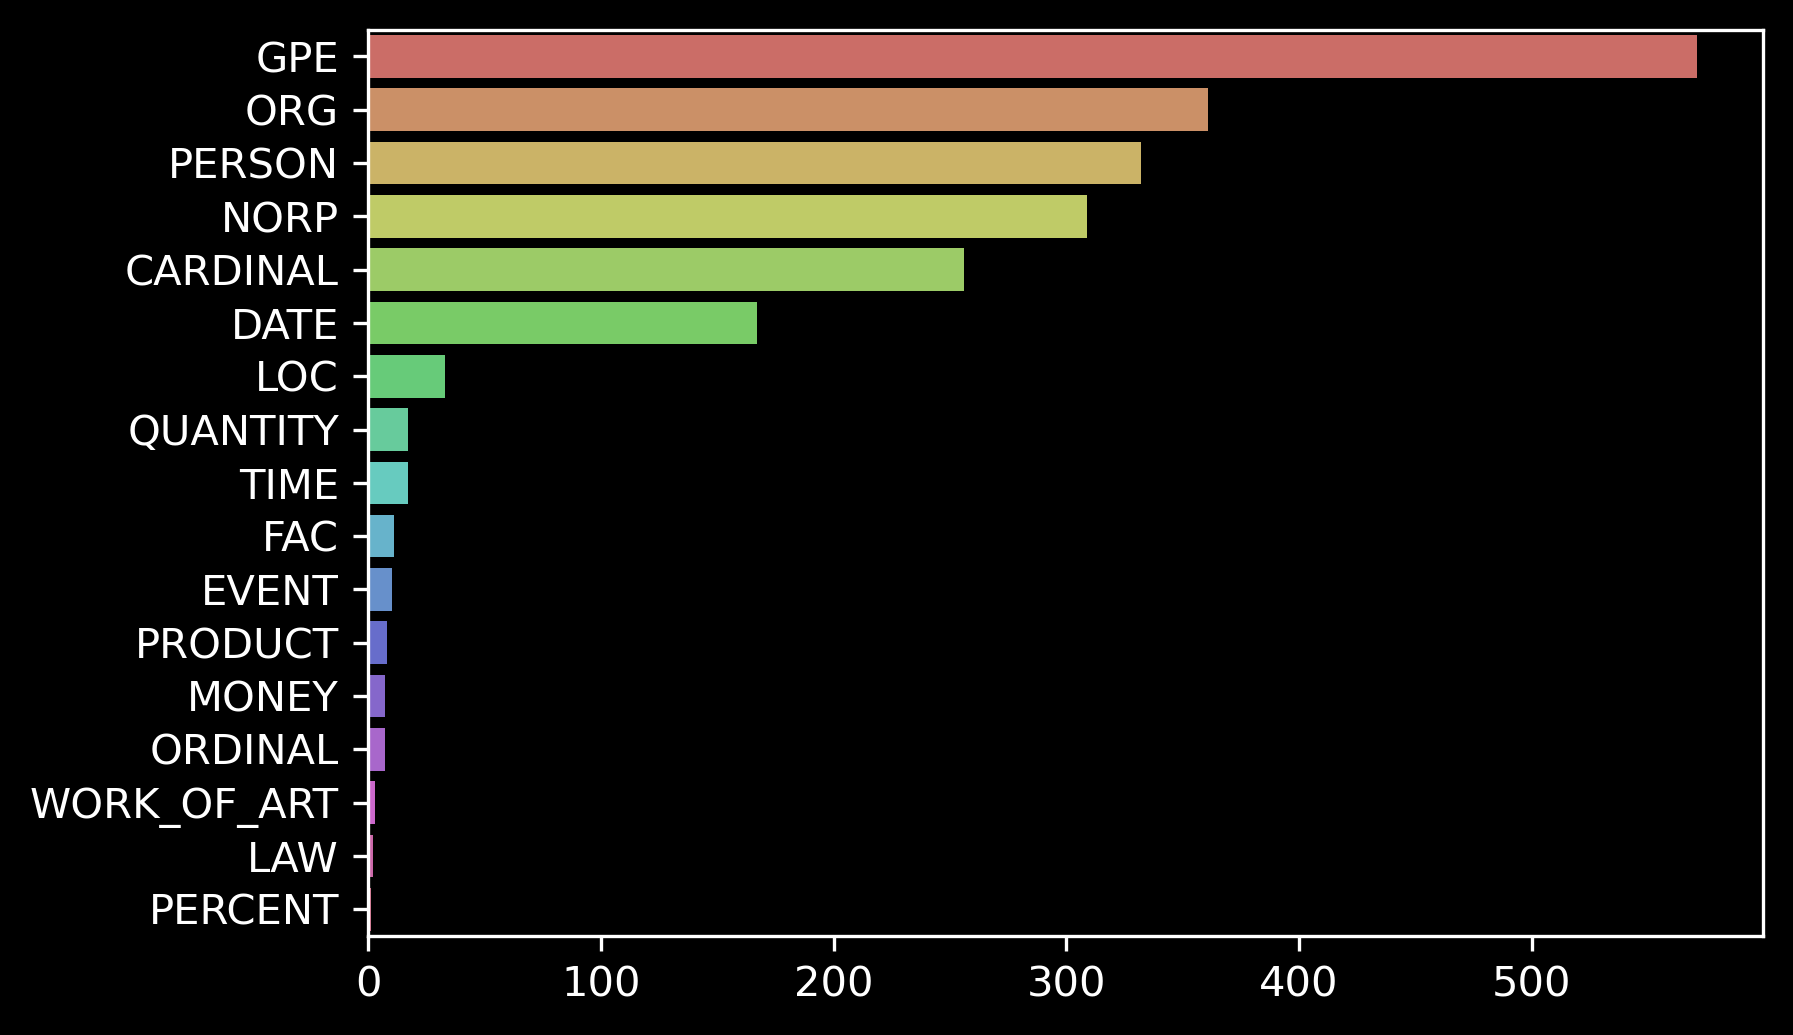

In [37]:
import spacy

nlp = spacy.load('en_core_web_md')

headline = headline.rename(columns={'tokenized_headline': 'headline'})

headline['ner'] = headline['headline'].apply(lambda x: [X.label_ for X in nlp(x).ents])

counter = dict(Counter([y for x in headline['ner'] for y in x]).most_common())

sns.barplot(list(counter.values()), list(counter.keys()), palette='hls');

----
#### Meaning of Spacy Named Entity Recognition Labels
----

In [38]:
pd.read_html('https://spacy.io/api/annotation')[6]

,Type,Description
0,PERSON,"People, including fictional."
1,NORP,Nationalities or religious or political groups.
2,FAC,"Buildings, airports, highways, bridges, etc."
3,ORG,"Companies, agencies, institutions, etc."
4,GPE,"Countries, cities, states."
5,LOC,"Non-GPE locations, mountain ranges, bodies of ..."
6,PRODUCT,"Objects, vehicles, foods, etc. (Not services.)"
7,EVENT,"Named hurricanes, battles, wars, sports events..."
8,WORK_OF_ART,"Titles of books, songs, etc."
9,LAW,Named documents made into laws.


----
----
## Profanity and Average Crowd Sentiment
----
----

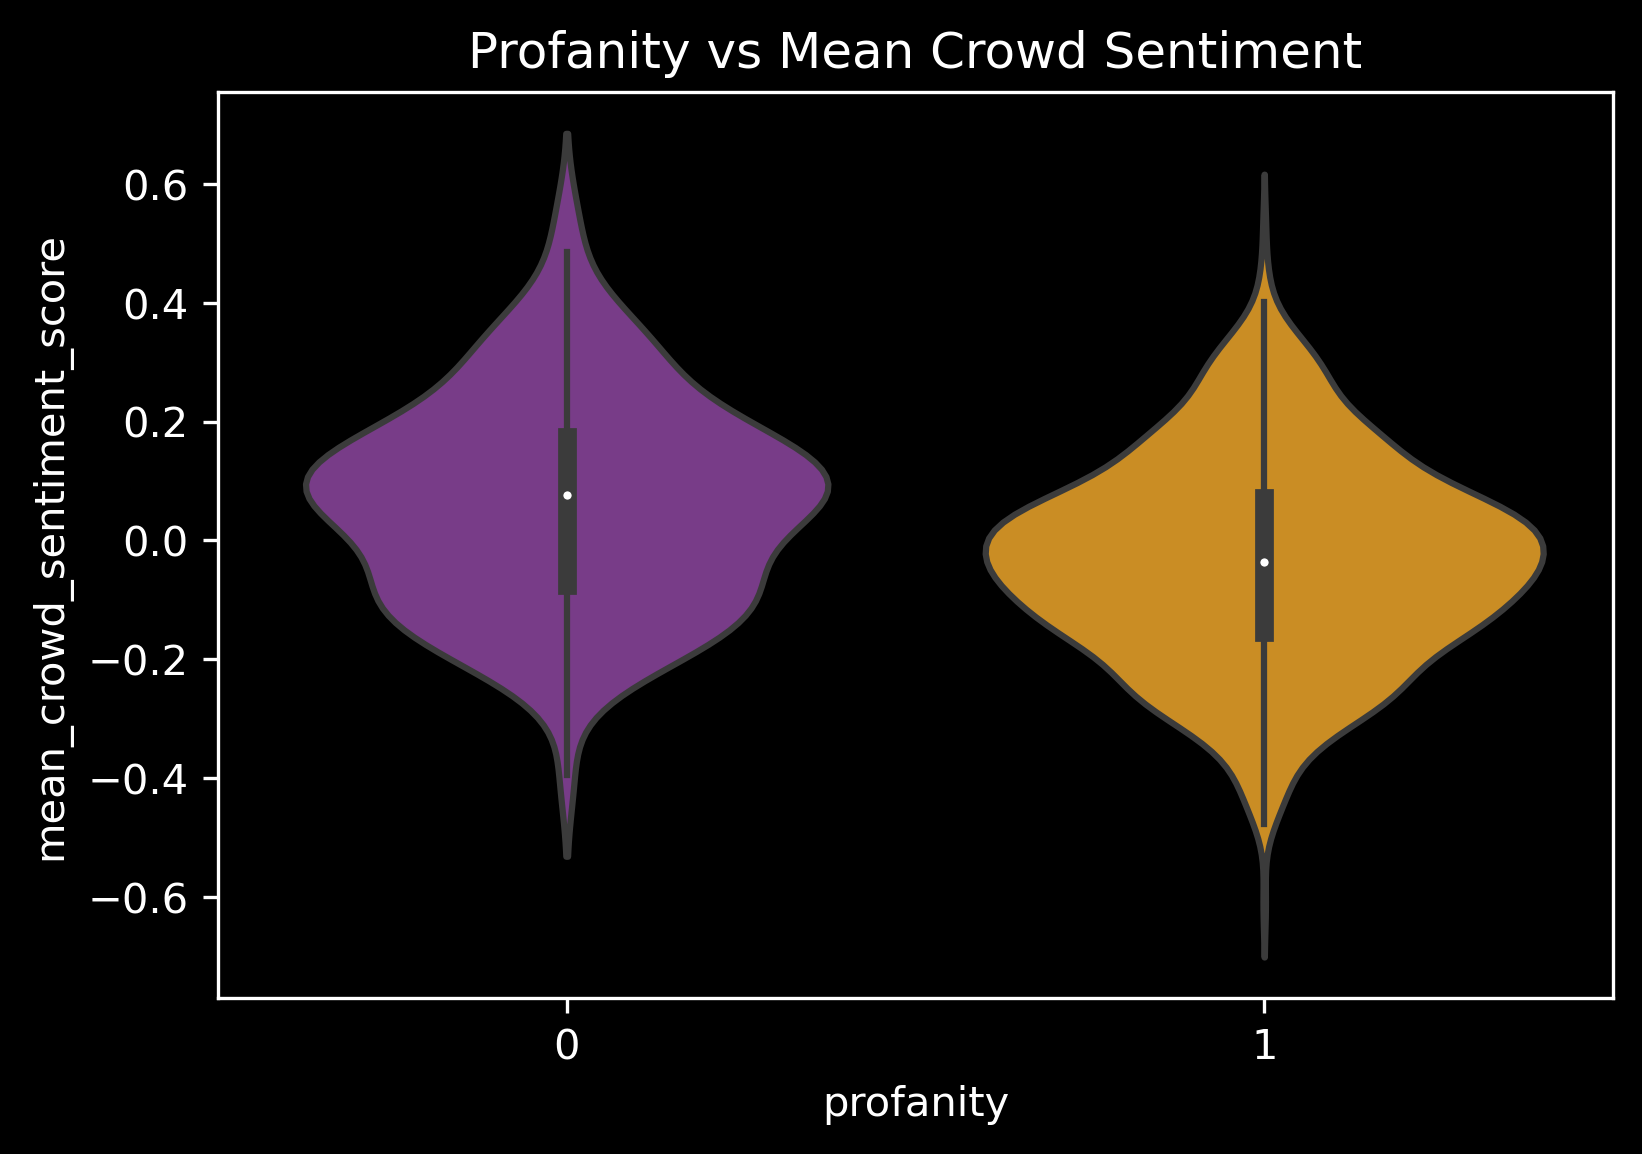

In [39]:
df['profanity'] = df['all_comments'].str.contains('(fuck|shit)').astype(int)

sns.violinplot(data=df, x='profanity', y='mean', palette='CMRmap')
plt.ylabel('mean_crowd_sentiment_score')
plt.title('Profanity vs Mean Crowd Sentiment');

----
----
## Average Number of Words in Comments
----
----

In [40]:
obj_df = df.select_dtypes('object').drop(['headline', 'tokenized_headline', 'all_comments', 'tokenized_comments'], axis=1)

stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))
tt = TweetTokenizer() 

tilted = obj_df.T.copy()

length = []
temp = []

for y in range(tilted.shape[1]):
    for item in tilted.loc[:, y]:
        for x in tt.tokenize(str(item)):
            if not x in stop_words and x.isalnum():
                temp.append(len(x))
    length.append(sum(temp)/len(temp))
    temp.clear()

obj_df['avg_word_len'] = length

df['avg_word_len'] = obj_df['avg_word_len']

----
### Average Number of Words, Crowd Label, and Profanity
----

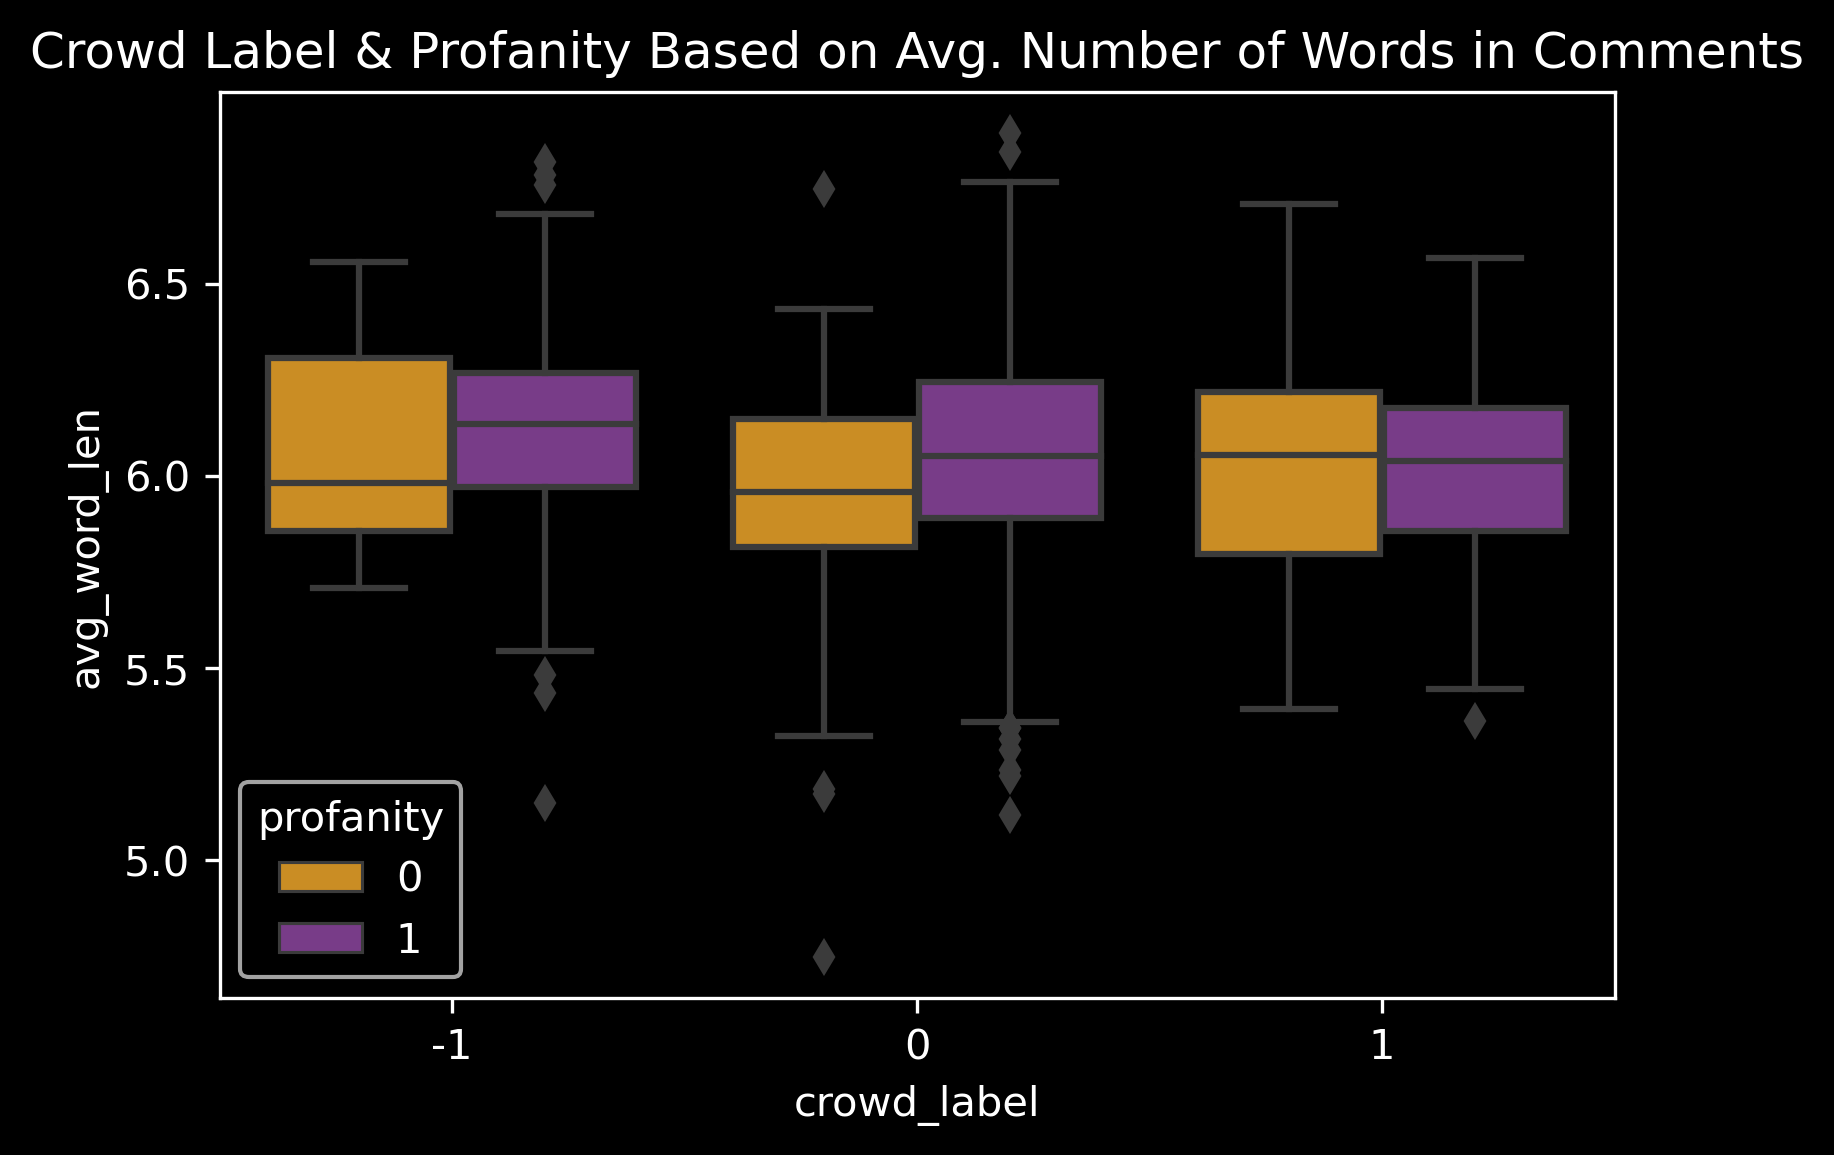

In [41]:
sns.boxplot(data=df, x='crowd_label', y='avg_word_len', hue='profanity', palette='CMRmap_r')

plt.title('Crowd Label & Profanity Based on Avg. Number of Words in Comments');

In [42]:
# df.to_csv('data/final-df.csv', index=False, header=df.columns.values)
# df.to_pickle('data/final-df.pkl')